In [ ]:
Bernat Sort Rufat
MD004_Advanced data analysis and visualization tools
Máster en Data Science


# Trabajo del Tema 8: Naive Bayes

Objetivos:

- **1. Limpieza de instancias**: Limpieza de texto de las instancias. Se valorará el uso de las técnicas empleadas y las explicaciones en el notebook.

- **2. Creación de modelo clasificador de Naive Bayes**: Se valorará el uso de técnicas empleadas como el split entre entrenamiento y validación y selección de métrica de optimización.

- **3. Optimización del modelo**: En base a los resultados obtenidos, ¿Somos capaces de mejorar nuestro modelo? Se valorará el uso de técnicas como Laplace smoothing, uso de la variable categórica package_name.

- **4. Conclusiones y vías abiertas**: ¿Qué resultados obtenemos en el modelo?, ¿Predice correctamente?, ¿En todas las apps?, ¿Qué datos podrían ayudarnos a mejorar la predicción?

## Carga de packages

In [119]:
# install.packages('tm')
library(tm)

# install.packages('SnowballC')
library(SnowballC)

# install.packages('wordcloud')
library('wordcloud')

library(caret)

# install.packages("e1071")
library(e1071)

## Carga de datos

In [120]:
# cargamos los datos en el df
sent_data <- read.csv(file="sentiment_dataset.csv", header=TRUE, sep=",", dec=".")

## Exploración básica inical de los datos

El csv “sentiment_dataset” incluye reviews que han dejado usuarios en la Google Play Store en referencia a 23 apps, incluyendo una valoración categórica sobre el análisis de sentimiento.

Los datos son los siguientes:
- package_name: Nombre de la app
- review: Texto del usuario con la review
- polarity: Sentimiento de polaridad de la review:
    - 1: Review con un sentimiento muy positivo o muy negativo
    - 0: Review con un sentimiento neutro

In [121]:
# las 3 primeras filas del df
head(sent_data,3)
# las 3 últimas filas del df
tail(sent_data,3)

,package_name,review,polarity
,<fct>,<fct>,<int>
1,com.facebook.katana,privacy at least put some option appear offline. i mean for some people like me it's a big pressure to be seen online like you need to response on every message or else you be called seenzone only. if only i wanna do on facebook is to read on my newsfeed and just wanna response on message i want to. pls reconsidered my review. i tried to turn off chat but still can see me as online.,0
2,com.facebook.katana,"messenger issues ever since the last update, initial received messages don't get pushed to the messenger app and you don't get notification in the facebook app or messenger app. you open the facebook app and happen to see you have a message. you have to click the icon and it opens messenger. subsequent messages go through messenger app, unless you close the chat head... then you start over with no notification and having to go through the facebook app.",0
3,com.facebook.katana,profile any time my wife or anybody has more than one post and i view them it would take me to there profile so that i can view them all at once. now when i try to view them it tells me that the page that i requested is not available. i've restarted my phone i even cleard the cache and i've uninstalled and reinstalled the app and it is still doing it. please fix it thank you,0


,package_name,review,polarity
,<fct>,<fct>,<int>
889,com.rovio.angrybirds,"ads are way to heavy listen to the bad reviews. there are ads after every round, whether you pass it or fail it. sometimes there are ads before the next round starts to. you spend more time on ads than game play. i develop web apps, and honestly many people rely on ads to make a living. i can appreciate that all to well. however, these developers have went far beyond that. frankly, they are disrespectful nitwits.",0
890,com.rovio.angrybirds,"fun works perfectly well. ads aren't as annoying as you think, especially for a free game.",1
891,com.rovio.angrybirds,they're everywhere i see angry birds everywhere because i can't stop playing this game. get out my head devs! 4 đ because nothing's perfect,1


- Comprobamos que efectivamente tenemos 3 variables: package_name, review y polarity. 

In [122]:
# dimensión del df (filas y columnas)
dim(sent_data)

[1] 891   3

- El dataset incluye 891 instancias (filas) y 3 variables (columnas).

In [123]:
# estructura interna compacta del df
str(sent_data)

'data.frame':	891 obs. of  3 variables:
 $ package_name: Factor w/ 23 levels "com.android.chrome",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ review      : Factor w/ 891 levels "  a avid fan of wapp; thats what we call it..  a recommendation.. if u guys can include a feature in which i ca"| __truncated__,..: 658 561 662 749 372 475 550 832 113 655 ...
 $ polarity    : int  0 0 0 0 0 0 0 0 0 0 ...


- Observamos que sent_data es un dataset con 891 observaciones y 3 variables. 
- La primera variable (package_name) es un factor con 23 niveles que representa los nombres de las distintas aplicaciones. 
- La segunda variable (review) es un factor con 891 niveles que representa las opiniones de los usuarios sobre las aplicaciones. 
- La tercera variable (polarity) es un número entero que representa la polaridad del sentimiento de las reseñas, donde 0 indica un sentimiento neutro y 1 indica una review con un sentimiento muy positivo o muy negativo. Esta variable en realidad es categórica así que la convertiremos a factor más adelante. 

In [124]:
# Proporción de clases
round(prop.table(table(sent_data$polarity))*100, digits = 1)


   0    1 
65.5 34.5 

- Observamos como de balanceado está el datset: no está balanceado un 50/50 pero tampoco está extremadamente desbalanceado. 

A continuación, convertimos polarity a factor para que tenga 2 niveles: 0 y 1

In [125]:
# Establecemos el tipo de dato a factor
sent_data$polarity = factor(sent_data$polarity)
sent_data$polarity


[1] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [38] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 [75] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
[112] 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 1
[149] 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 1 1 1 1 0 1 1 0 1 0 0 0 1 0 1
[186] 1 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[223] 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0
[260] 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[297] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[334] 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 1 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0
[371] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
[408] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0
[445] 0 0 1 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1
[482] 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 0 1 0 1 1 1 0 1 1 0 1 1 1 0 0
[519] 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 1 0 0 1 1 0 1 1 1 1 1 1 0 1 0
[556] 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1
[593] 1 1 0 0 0 1 0 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 1 1 1 0 1 1 1
[630] 0 0 1 1 1 1 1 0 0 0 1 0 0 0 1 1 1 1 0 0 1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1
[667] 1 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
[704] 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0
[741] 0 1 0 1 0 0 0 0 0 0 0 1 1 1 1 0 1 0 1 0 1 1 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0
[778] 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 1 0 0 1 0 0 0 1 1 1 1 1 1 1
[815] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[852] 1 1 1 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 0 1 1 1 1 1
[889] 0 1 1
Levels: 0 1

## Transformación y limpieza del dataset

- Primero creamos el corpus: una matriz documento-término creada a partir de la variable review, que representa las reseñas dadas por los usuarios a las aplicaciones. La función VCorpus del paquete tm se utiliza para crear el corpus, dondeVectorSource se utiliza para convertir los datos de texto en un vector de términos. 
- Luego tenemos que homogeneizar todas esas palabras. Para ello aplicamos una serie de transformaciónes que veremos a continuación. 

**VENTAJAS**

- A nivel computacional los datos se guardan en la memoria, por lo que computacionalmente es más eficiente.
- El tipo de almacenamiento corpus tiene funciones que nos permiten manipular textos de una forma eficiente con funciones predefinidas.



### Creación del corpus

In [126]:
data_corpus = VCorpus(VectorSource(sent_data$review),readerControl = list(language = 'en'))
print(data_corpus)

<<VCorpus>>
Metadata:  corpus specific: 0, document level (indexed): 0
Content:  documents: 891


- Tenemos 891 registros.

### Función que aplica las transformaciones

- Las funciones replacePunctuation y removeAccents definen las operaciones de tratamiento de texto para limpiar las reviews del corpus. La función replacePunctuation sustituye los caracteres de puntuación del texto por espacios, mientras que la función removeAccents elimina los acentos del texto.

- La función clean_corpus aplica una serie de operaciones de procesamiento de texto al corpus de entrada para limpiar y preprocesar los datos de texto. Las siguientes operaciones se realizan en el corpus en el orden especificado:

    - Convertir todo el texto a minúsculas utilizando tm_map y tolower
    - Eliminar los números con tm_map y removeNumbers
    - Eliminar las palabras clave en inglés con tm_map, removeWords y stopwords('english')
    - Eliminar otras palabras clave con tm_map, removeWords y stopwords()
    - Eliminar los signos de puntuación con tm_map y removePunctuation
    - Sustituir los signos de puntuación por espacios con tm_map y replacePunctuation
    - Eliminar acentos con tm_map y removeAccents
    - Eliminar los espacios en blanco al principio y al final de cada elemento de texto mediante tm_map y stripWhitespace
    - Convertir el corpus en documentos de texto sin formato (plain text) mediante tm_map y PlainTextDocument
    - La función devuelve el corpus final limpio

In [127]:
replacePunctuation = function(x) {gsub('[[:punct:]]', ' ', x)}
removeAccents = function(x) {
  x = chartr('àáâäèéêëìíîïòóôöùúûü', 'aaaaeeeeiiiiooooouuuu', x)
  return(x)
}

clean_corpus = function(corpus){
               data_corpus_clean = tm_map(corpus, content_transformer(tolower))
               data_corpus_clean = tm_map(data_corpus_clean, removeNumbers)   
               data_corpus_clean = tm_map(data_corpus_clean, removeWords, stopwords('english'))
               data_corpus_clean = tm_map(data_corpus_clean, removeWords, stopwords())        
               data_corpus_clean = tm_map(data_corpus_clean, removePunctuation)     
               data_corpus_clean = tm_map(data_corpus_clean, replacePunctuation)    
               data_corpus_clean = tm_map(data_corpus_clean, removeAccents)    
               data_corpus_clean = tm_map(data_corpus_clean, stripWhitespace)      
               data_corpus_clean = tm_map(data_corpus_clean, PlainTextDocument)   
  return(data_corpus_clean)
}

In [128]:
data_corpus = VCorpus(VectorSource(sent_data$review),readerControl = list(language = 'en'))
data_corpus_clean = clean_corpus(data_corpus) 
print(lapply(data_corpus[1], as.character))
print(lapply(data_corpus_clean[1], as.character))

$`1`
[1] " privacy at least put some option appear offline. i mean for some people like me it's a big pressure to be seen online like you need to response on every message or else you be called seenzone only. if only i wanna do on facebook is to read on my newsfeed and just wanna response on message i want to. pls reconsidered my review. i tried to turn off chat but still can see me as online."

$`character(0)`
[1] " privacy least put option appear offline mean people like big pressure seen online like need response every message else called seenzone wanna facebook read newsfeed just wanna response message want pls reconsidered review tried turn chat still can see online"



- En este ejemplo observamos que la función clean_corpus ha limpiado con éxito el primer documento del corpus. El documento original tenía mayúsculas, signos de puntuación, números, stopwords y tildes, pero el documento limpiado está en minúscula y ha eliminado estos elementos.

### Wordclouds

Para ver el comportamiento de una variable categórica hacemos una nube, en este caso, una nube de palabras:
- Graficamos las 30 palabras más importantes, con más peso (que más se repiten), tanto de las reviews con un sentimiento muy positivo o muy negativo (1) como de las reviews con un sentimiento neutro (0).

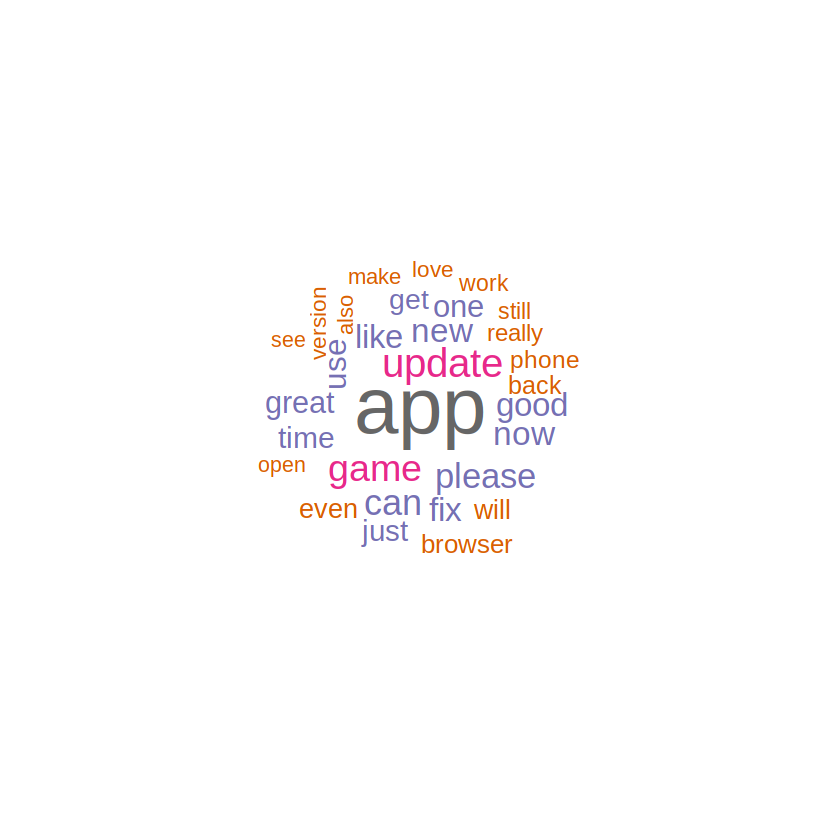

In [131]:
options(repr.plot.width = 7, repr.plot.height = 7)

wordcloud(data_corpus_clean, max.words = 30, random.order = F, colors = brewer.pal(name = "Dark2", n = 8))

- Observamos que algunas de las palabras con más peso son app, update y game entre otras. 

Graficamos las 30 palabras más importantes, con más peso (que más se repiten), de las reviews con un sentimiento neutro (0):

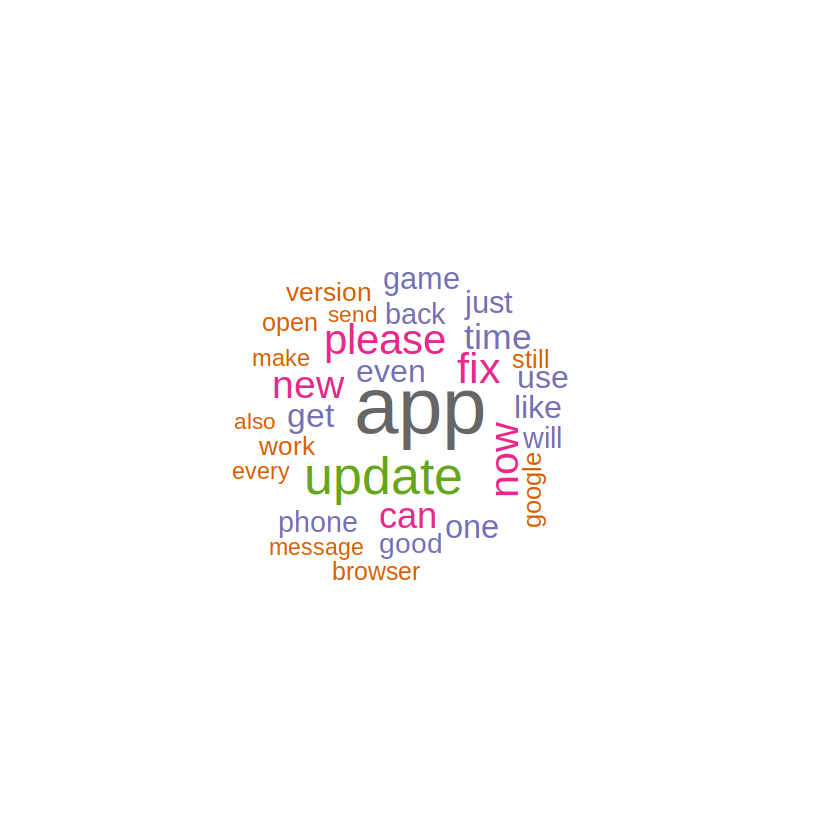

In [132]:
sent_data_zero = subset(sent_data, sent_data$polarity==0)
data_corpus_zero = VCorpus(VectorSource(sent_data_zero$review),readerControl = list(language = 'en'))
data_corpus_clean_zero = clean_corpus(data_corpus_zero) 
wordcloud(data_corpus_clean_zero, max.words = 30, random.order = F, colors = brewer.pal(name = "Dark2", n = 8))

- Observamos que algunas de las palabras con más peso son app, update, please, new, fix, now y can, entre otras.

Graficamos las 30 palabras más importantes, con más peso (que más se repiten), de las reviews con un sentimiento muy positivo o muy negativo (1):

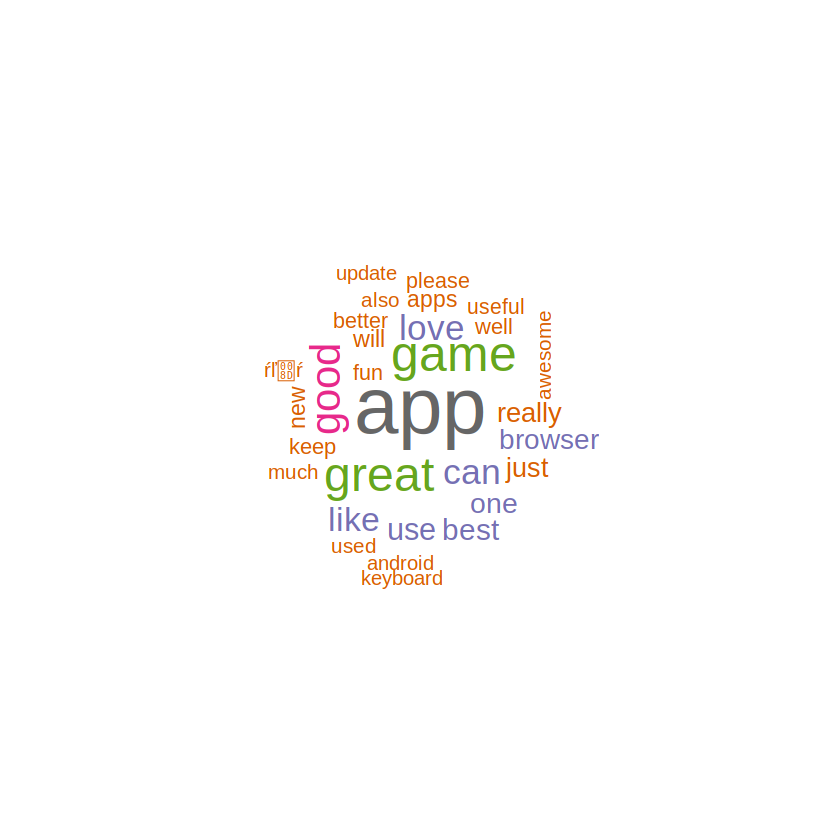

In [133]:
sent_data_one = subset(sent_data, sent_data$polarity==1)
data_corpus_one = VCorpus(VectorSource(sent_data_one$review),readerControl = list(language = 'en'))
data_corpus_clean_one = clean_corpus(data_corpus_one) 

wordcloud(data_corpus_clean_one, max.words = 30, random.order = F, colors = brewer.pal(name = "Dark2", n = 8))

- Observamos que algunas de las palabras con más peso son app, game, great, good y love, entre otras. 

- Parece ser que sí hay diferencias entre las 30 palabras más importantes de las reviews con un sentimiento muy positivo o muy negativo (1) y de las reviews con un sentimiento neutro (0). 

## Separación en Train & Test

- Lo que necesita el modelo es tener el conteo de esas palabras, saber que palabras son más representativas para las reviews con un sentimiento muy positivo o muy negativo (1) y para las reviews con un sentimiento neutro (0).

- Lo que estamos calculando es, la probabilidad que esa review sea una review muy positiva o muy negativa condicionada a que tenga, por ejemplo,  la palabra 'great'. 

- Lo primero que haremos es crear una matriz que contenga los 891 registros, pero va a tener una columna para cada una de las palabras que tenemos recopiladas en nuestro corpus:  DocumentTermMatrix. Cada columna es una palabra. 

In [140]:
dtm = DocumentTermMatrix(data_corpus_clean)
dtm

<<DocumentTermMatrix (documents: 891, terms: 3821)>>
Non-/sparse entries: 17374/3387137
Sparsity           : 99%
Maximal term length: 36
Weighting          : term frequency (tf)

- El objeto dtm es una Matriz Documento-Término, que es una representación matricial de un corpus de documentos de texto, donde las filas representan los documentos y las columnas los términos (es decir, las palabras) del vocabulario.
- La matriz tiene 891 filas (documentos) y 3821 columnas (términos). 
- Hay 17374 entradas distintas de cero (es decir, términos que aparecen en los documentos) en la matriz y 3387137 entradas en total, lo que supone una dispersión del 99%, es decir, que la mayoría de las entradas de la matriz son 0 (es decir, los términos no están presentes en los documentos). 
- El término más largo del vocabulario tiene 36 caracteres.
- La frecuencia del término (tf) indica que el esquema de ponderación utilizado en la matriz es la frecuencia del término, lo que significa que los valores de la matriz representan el número de apariciones de un término en un documento.

In [145]:
# 5 primeras filas y 5 primeras columnas de la DTM.
inspect(dtm[1:5, 1:5])

<<DocumentTermMatrix (documents: 5, terms: 5)>>
Non-/sparse entries: 0/25
Sparsity           : 100%
Maximal term length: 28
Weighting          : term frequency (tf)
Sample             :
              Terms
Docs           ˇŕľ\u008dŕ ă\u0080\u008b
  character(0)          0             0
  character(0)          0             0
  character(0)          0             0
  character(0)          0             0
  character(0)          0             0
              Terms
Docs           a\u0098\u0085a\u0098\u0085a\u0098\u0085a\u0098\u0085besta\u0098\u0085a\u0098\u0085a\u0098\u0085a\u0098\u0085
  character(0)                                                                                                            0
  character(0)                                                                                                            0
  character(0)                                                                                                            0
  character(0)                        

In [147]:
str(dtm)

List of 6
 $ i       : int [1:17374] 1 1 1 1 1 1 1 1 1 1 ...
 $ j       : int [1:17374] 171 333 460 469 531 1045 1122 1182 1751 1835 ...
 $ v       : num [1:17374] 1 1 1 1 1 1 1 1 1 1 ...
 $ nrow    : int 891
 $ ncol    : int 3821
 $ dimnames:List of 2
  ..$ Docs : chr [1:891] "character(0)" "character(0)" "character(0)" "character(0)" ...
  ..$ Terms: chr [1:3821] "ˇŕľ\u008dŕ" "ă\u0080\u008b" "a\u0098\u0085a\u0098\u0085a\u0098\u0085a\u0098\u0085besta\u0098\u0085a\u0098\u0085a\u0098\u0085a\u0098\u0085" "a\u0098\u0086a\u0098\u0086a\u0098\u0086a\u0098\u0086a\u0098\u0086" ...
 - attr(*, "class")= chr [1:2] "DocumentTermMatrix" "simple_triplet_matrix"
 - attr(*, "weighting")= chr [1:2] "term frequency" "tf"


- En total tenemos los 891 registros (reviews) y un total de 3821 palabras que vamos a tener que contar si están o no y cuántas veces aparecen en la review.  
- Esto lo hacemos mediante la suma de palabras por review y una tabla de frecuencias:
    - Creamos una tabla de frecuencias para los términos de la matriz documento-término (dtm):
    - Calculamos la suma de la frecuencia de cada término (es decir, el número de veces que cada término aparece en todos los documentos).
    - Almacenamos los nombres de los términos y los valores de frecuencia en un df llamado tabla_frec.
    - Ordenamos la tabla de frecuencias en orden descendente de frecuencia de términos.
    - Mostramos la tabla de frecuencias en orden descendente.
    

In [119]:
termFreq = colSums(as.matrix(dtm))
head(termFreq)
tabla_frec = data.frame(term = names(termFreq), freq = termFreq)
tabla_frec = tabla_frec[order(-tabla_frec[,2]),]
head(tabla_frec)

ˇŕľ\u008dŕ 
                                                                                                           1 
                                                                                               ă\u0080\u008b 
                                                                                                           4 
a\u0098\u0085a\u0098\u0085a\u0098\u0085a\u0098\u0085besta\u0098\u0085a\u0098\u0085a\u0098\u0085a\u0098\u0085 
                                                                                                           1 
                                           a\u0098\u0086a\u0098\u0086a\u0098\u0086a\u0098\u0086a\u0098\u0086 
                                                                                                           1 
                                                                                                     aafnaii 
                                                                                                           1 
                                                                                                    aakhirat 
                                                                                                           1

,term,freq
,<fct>,<dbl>
app,app,480
use,use,299
updat,updat,243
game,game,179
work,work,176
fix,fix,171


- Observamos que app aparece 480 veces, use aparece 299 veces, update 243 veces, etc. 

### Construcción del Modelo
- Primero dividimos en train y test: dividimos el dataset original por la variable polarity.

In [150]:
# semilla para la reproducibilidad
set.seed(555)

# Creamos el data partition de la función caret con un 80 - 20 split
inTrain <- createDataPartition(y = sent_data$polarity
                                  , p = .80
                                  , list = FALSE
                                  , times = 1)
# Definimos los datasets originales entre train y test
data.train<-sent_data[inTrain,]
data.test<-sent_data[-inTrain,]

# Revisamos el split
str(data.train)
str(data.test)

'data.frame':	714 obs. of  3 variables:
 $ package_name: Factor w/ 23 levels "com.android.chrome",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ review      : Factor w/ 891 levels "  a avid fan of wapp; thats what we call it..  a recommendation.. if u guys can include a feature in which i ca"| __truncated__,..: 658 561 662 749 475 550 832 113 854 279 ...
 $ polarity    : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
'data.frame':	177 obs. of  3 variables:
 $ package_name: Factor w/ 23 levels "com.android.chrome",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ review      : Factor w/ 891 levels "  a avid fan of wapp; thats what we call it..  a recommendation.. if u guys can include a feature in which i ca"| __truncated__,..: 372 655 510 278 127 519 236 311 244 614 ...
 $ polarity    : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...


- De mi matriz de palabras, me quedo con la parte que va a ir al train y la parte que va a ir al test. 
- A continuación verificamos que se siga manteniendo la proporción que tenía en mi dataset original (65.5% - 34.5%): la proporción se debe seguir manteniendo.


In [151]:
# Separamos el corpus según la clase
corpus.train = data_corpus_clean[inTrain]
corpus.test  = data_corpus_clean[-inTrain]

# Y finalmente el Document term matrix
dtm.train = dtm[inTrain, ]
dtm.test  = dtm[-inTrain, ]

# Comprobamos que el desbalanceo de clases es el adecuado
print("Training")
round(prop.table(table(data.train$polarity))*100, 2)
print("Test")
round(prop.table(table(data.test$polarity))*100, 2)

[1] "Training"



    0     1 
65.55 34.45 

[1] "Test"



    0     1 
65.54 34.46 

- Observamos que el desbalanceo de clases es muy parecido: se mantiene la proporción. 

No podemos trabajar con 3821 variables o palabras, nos tenemos que simplificar la vida: queremos trabajar con las palabras que más veces se hayan repetido, que son las que más información nos van a dar. 
En este caso, conservamos las palabras que como mínimo se repitan 10 veces. 

In [152]:
freq_terms = findFreqTerms(dtm.train, 10)
freq_terms

[1] "able"          "account"       "add"           "ads"          
  [5] "almost"        "already"       "also"          "always"       
  [9] "amazing"       "android"       "angry"         "annoying"     
 [13] "another"       "anymore"       "anything"      "app"          
 [17] "application"   "apps"          "automatically" "available"    
 [21] "away"          "awesome"       "back"          "background"   
 [25] "bad"           "base"          "become"        "best"         
 [29] "better"        "big"           "birds"         "bit"          
 [33] "bookmarks"     "browser"       "browsers"      "browsing"     
 [37] "bug"           "bugs"          "button"        "buy"          
 [41] "call"          "can"           "cant"          "change"       
 [45] "chat"          "chrome"        "click"         "close"        
 [49] "come"          "connect"       "connection"    "contact"      
 [53] "contacts"      "cool"          "crashes"       "data"         
 [57] "day"           "days"          "default"       "design"       
 [61] "desktop"       "developers"    "device"        "devices"      
 [65] "different"     "done"          "dont"          "download"     
 [69] "downloading"   "dropbox"       "easy"          "edit"         
 [73] "emojis"        "end"           "english"       "enough"       
 [77] "error"         "especially"    "even"          "ever"         
 [81] "evernote"      "every"         "everything"    "excellent"    
 [85] "facebook"      "far"           "fast"          "feature"      
 [89] "features"      "feed"          "files"         "find"         
 [93] "fine"          "firefox"       "first"         "fix"          
 [97] "fixed"         "force"         "found"         "free"         
[101] "friends"       "frozen"        "full"          "fun"          
[105] "function"      "galaxy"        "game"          "get"          
[109] "gets"          "getting"       "give"          "goes"         
[113] "going"         "gone"          "good"          "google"       
[117] "got"           "great"         "group"         "guys"         
[121] "hamro"         "hangouts"      "happened"      "happens"      
[125] "happy"         "hard"          "hate"          "help"         
[129] "high"          "hope"          "hours"         "however"      
[133] "idea"          "improve"       "include"       "install"      
[137] "installed"     "instead"       "interface"     "internet"     
[141] "issue"         "issues"        "job"           "just"         
[145] "keep"          "keeps"         "keyboard"      "kind"         
[149] "know"          "last"          "latest"        "left"         
[153] "less"          "let"           "level"         "levels"       
[157] "like"          "list"          "little"        "load"         
[161] "loading"       "log"           "long"          "longer"       
[165] "look"          "looking"       "loot"          "lost"         
[169] "lot"           "love"          "loved"         "made"         
[173] "make"          "makes"         "many"          "memory"       
[177] "menu"          "message"       "messages"      "messenger"    
[181] "mini"          "missing"       "mobile"        "mode"         
[185] "money"         "much"          "must"          "need"         
[189] "needs"         "nepali"        "network"       "never"        
[193] "new"           "news"          "next"          "nice"         
[197] "note"          "notes"         "nothing"       "notification" 
[201] "notifications" "now"           "offline"       "old"          
[205] "one"           "ones"          "online"        "open"         
[209] "opera"         "option"        "options"       "page"         
[213] "pages"         "part"          "password"      "people"       
[217] "person"        "phone"         "photos"        "pictures"     
[221] "play"          "playing"       "please"        "pls"          
[225] "plz"           "poor"          "post"          "posts"        
[229] "power

Por tanto, reducimos la matriz y nos quedamos solo con esas columnas que están aquí:

In [154]:
freq_terms = findFreqTerms(dtm.train, 10)
reduced_dtm.train = DocumentTermMatrix(corpus.train, list(dictionary=freq_terms))
reduced_dtm.test =  DocumentTermMatrix(corpus.test, list(dictionary=freq_terms))

#REvisamos cuantas columnas reducimos
ncol(dtm.train)
ncol(reduced_dtm.train)
ncol(dtm.test)
ncol(reduced_dtm.test)

[1] 3821

[1] 359

[1] 3821

[1] 359

- Hemos pasado de tener 3821 variables o palabras a tener 359 palabras. 

Ahora ya podemos construir el clasificador de Naive Bayes.

## Clasificador Naive Bayes

Naive Bayes funciona con factores (necesita 0's y 1's) mientras que nuestra estructura DMT tiene valores numéricos. A continuación definimos una función que nos ayude a convertir números en factores y la aplicamos a las matrices reducidas:

In [155]:
convert_counts = function(x) {
  x = ifelse(x > 0, 1, 0)
  x = factor(x, levels = c(0, 1), labels=c("No", "Yes"))
  return (x)
}

# apply() allows us to work either with rows or columns of a matrix.
# MARGIN = 1 is for rows, and 2 for columns
reduced_dtm.train = apply(reduced_dtm.train, MARGIN=2, convert_counts)
reduced_dtm.test  = apply(reduced_dtm.test, MARGIN=2, convert_counts)

- La función "convert_counts" toma una matriz x y sustituye los valores mayores que 0 por 1 y los valores iguales a 0 por 0. A continuación, convierte estos valores binarios en una variable factorial con dos niveles: "No" para 0 y "Sí" para 1. Por último, aplica esta función a las columnas de dos matrices, reduced_dtm.train y reduced_dtm.test, mediante la función apply(). El resultado es la transformación de los datos de la matriz en una variable factorial, en la que cada celda es "Sí" o "No".

Invocamos a la función NB dónde le pasamos la matriz reducida y la información de cada uno de los registros: si eran reviews con un sentimiento muy positivo o muy negativo (1) o reviews con un sentimiento neutro (0).

Lo entrenamos:
- La variable objetivo representa la polaridad del texto en la dtm.
- El modelo entrenado resultante se almacena en el objeto subject_classifier.


Aplicamos el modelo entrenado al test set:
- Utilizamos el modelo entrenado para generar predicciones sobre la matriz documento-término de prueba (reduced_dtm.test) llamando a la función predict y almacenando las predicciones en el objeto subject_test.predicted.

In [156]:
# store our model in sms_classifier
subject_classifier = naiveBayes(reduced_dtm.train # Dataset de entrenamiento
                            , data.train$polarity) # Target de entrenamiento

subject_test.predicted = predict(subject_classifier,  # Predicciones utilizando el modelo creado con los datos de entrenamiento
                             reduced_dtm.test) # Generación de predicciones para el dataset de test

In [157]:
# confusion matrix
confusionMatrix(subject_test.predicted, data.test$polarity)

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 102   9
         1  14  52
                                          
               Accuracy : 0.8701          
                 95% CI : (0.8114, 0.9158)
    No Information Rate : 0.6554          
    P-Value [Acc > NIR] : 7.598e-11       
                                          
                  Kappa : 0.7178          
                                          
 Mcnemar's Test P-Value : 0.4042          
                                          
            Sensitivity : 0.8793          
            Specificity : 0.8525          
         Pos Pred Value : 0.9189          
         Neg Pred Value : 0.7879          
             Prevalence : 0.6554          
         Detection Rate : 0.5763          
   Detection Prevalence : 0.6271          
      Balanced Accuracy : 0.8659          
                                          
       'Positive' Class : 0               
                              

- El modelo clasificó correctamente 102 reviews con un sentimiento neutro (0) y 52 reviews con un sentimiento muy positivo o muy negativo (1). No obstante, clasificó incorrectamente 14 reviews que en realidad eran reviews con un sentimiento neutro como reviews con sentimiento muy positivo o muy negativo (1) y clasificó incorrectamente 9 reviews que en realidad eran reviews con sentimiento muy positivo o muy negativo (1) ccomo reviews con sentimiento neutro. 

- Obtenemos un 87% de aciertos (accuracy = 0.8701).


A priori la accuacy del modelo parece buena, pero nos interesa entender cómo son las instancias en las que hay error de predicción.

Visualizamos como son las reviews que se han clasificado como reviews con un sentimiento muy positivo o muy negativo (1) cuando en realidad eran reviews con un sentimiento neutro (0):


In [159]:
# Visualizamos las instancias que han sido filtradas erróneamente: son 0 pero las ha clasificado como 1
data.test[(subject_test.predicted != data.test$polarity) # Seleccionamos las instancias con error en la predicción
          & (data.test$polarity == '0'),] # Seleccionamos las instancias con etiqueta 0

,package_name,review,polarity
,<fct>,<fct>,<fct>
154,com.king.candycrushsaga,complete bull was on 1186 and went to play and had lost all my boosters had over 100 different boosters saved up some i payed for never again,0
160,com.imangi.templerun2,book and their use as a great christmas navarro was gonna get a lot of different names for christmas is a screamer and i can't remember if my sis and baking and making everything so perfect for me to believe in things and i'll return to go over in a few minutes ago and i have a great day at home soon and their little room in the kids to school with your questions,0
180,com.imangi.templerun2,temple run -pretty good the game is fun.but i would like it if it didn't have so many videos for one specific app most of the time. it would also be nice if you could choose to be a boy or a girl character. overall the game is okay/pretty good,0
205,com.supercell.clashofclans,hey supercell i would like u to put in a skype in the clan chats when peaple r battleing because u could help them out because u see things they dont and some type of healing defense. and thx for the town hall 11 if u do 5 stars,0
272,com.android.chrome,average not so good for watching online videos for watching videos i would prefer stock aosp google browser or uc browser + mx player.,0
417,com.facebook.orca,not good i had for a while but is not working keeps messing up my face book must have a big because i deleted and my face book works,0
553,com.dropbox.android,"it used up my battery!!!!!! i forgot to switch back to my home screen and keep opening dropbox app, then my battery dropped from 50% to 25% in 30mins. it really is a 'drop'box.",0
563,jabanaki.todo.todoly,has potential could be better but it conts to crash after some use. love the web version though!,0
566,jabanaki.todo.todoly,dud on droid4 doesn't work on my new droid4,0


Visualizamos como son las reviews que se han clasificado como reviews con un sentimiento neutro (0) cuando en realidad eran reviews con un sentimiento muy positivo o muy negativo (1):

In [160]:
# reviews que son 1 pero las ha clasificado como 0
data.test[(subject_test.predicted != data.test$polarity) # Seleccionamos las instancias con error en la predicción
          & (data.test$polarity == '1'),] # Seleccionamos las instancias con etiqueta 1

,package_name,review,polarity
,<fct>,<fct>,<fct>
176,com.imangi.templerun2,"it's alrightđ¤ i don't get to go on the cross wire i've got to 200 000 why why why.,đ˘đđđđâ â â đđľđşđăđđi forgot to tell u no sound on this game ........i hate it",1
189,com.imangi.templerun2,"everyone able to see highest score i would like to given one idea ,i could not saw everyone higher score atleast 1 to 5 member, i want to see each and everyone highest score through on my mobile , if you create this option, everyone will be try to achive the highest score ,i hope you will be create this option of temple run 2",1
358,com.google.android.talk,won't make calls i have 5 bars on verizon 4g but it keeps saying can not connect call. so far had only connected 1 call when i had 1 bar and the other person couldn't hear me. i have tried at over 20 different locations in the city i live in all around 4 or 5 bars. no calls can be made. fix this.,1
441,com.whatsapp,occasionally i won't receive a notification of a message(s) so i don't know that someone has replied until i actually open the app and then suddenly lots of messages come through... 5 stars if that can be fixed,1
490,com.Slack,works really well slack for android works flawlessly on my nexus 7 and is way better to use than the ios and desktop versions. the latest update has fixed a couple of the ui/ux issues introduced in the previous update and glad to see the scrollbar's back when you swipe up to view the channel history.,1
613,com.evernote,"really cool and organized. the new update is really amazing, the widgets are cool, however, it would be helpful if you could add right to left reading and writing support (like hebrew, 'cause when i want to add check box the text removed to the left). also, you need to add an option to change the size of the preview (don't like it's so small), and app animations would be nice. something else to your attention: i want to by the app, but it really (really) expensive. if it was cheaper and one time charge i would buy it.",1
629,com.uc.browser.en,update few things.... uc mini is very speed for dwnldng and other things. and plz provide an option for online videos dwnldng and youtube dwnldng. i hope iam expecting this feature from you as soon as.,1
795,org.mozilla.firefox,"i've used firefox on all my mobile devices and computers for years, but since this latest update it's become unusable on my galaxy note 10.1. links either don't work or take you to a different link on the page and the tops & bottoms of pages are obscured so only around a third of the page is visible and search boxes can't be accessed. i hate the idea of changing to chrome etc, but my tablet has been rendered useless for browsing. please sort it out mozilla.",1
820,com.hamropatro,fixed sticky notification :) but can't sign in :( the stick notification is not displayed is fixed thank u :) but can't log in please help,1


## Mejora del Modelo - Laplace Smoothing 

En este caso hemos hecho un filtro de las palabras más repetidas, pero puede darse que en algún momento nuestro modelo tenga que valorar la probabilidad según NB para una palabra en la que no haya sido entrenado y por lo tanto nos encontramos con un caso de probabilidad 0.

Para este tipo de casos, contamos con una variación de NB en el que le aplicamos un factor de Laplace smoothing

![alt text](https://miro.medium.com/max/1188/1*pvtiVc9Sqs7NJ23u0KHOpg.png?auto=webp&quality=85,70"Title")

Explicación más extensa: https://towardsdatascience.com/laplace-smoothing-in-na%C3%AFve-bayes-algorithm-9c237a8bdece

- Puede ser que nos lleguen textos que tengan palabras que no están consideradas en nuestro modelo. 
- Queremos minimizar esa probabilidad de 0: si no tengo esa palabra, me va a decir que la probabilidad de que sea una review con un sentimiento muy positivo o muy negativo es 0. 
- Una forma de suavizar este efecto es poner el hiperparámetro de Laplace.  
     - pone una cantidad en el numerador y en el denominador que hace que no sea ese 0%.
- Poco a poco vamos haciendo crecer este parámetro y vamos viendo como cambia la matriz (los resultados). 

<U>Nota:<U>
- En general, si el modelo se utiliza para identificar el sentimiento en las opiniones de los clientes, clasificar erróneamente una opinión muy positiva o negativa como neutral podría ser potencialmente perjudicial. Esto se debe a que la empresa podría no tomar las medidas adecuadas basándose en la opinión del cliente, lo que tendría un impacto negativo en la satisfacción del cliente y podría causar pérdidas en el negocio.

- Por otro lado, clasificar erróneamente una opinión neutra como muy positiva o negativa podría llevar a estrategias de marketing o esfuerzos de captación de clientes incorrectos, pero probablemente no tendría consecuencias tan graves como clasificar erróneamente una opinión muy positiva o negativa.

- Por tanto, consideramos que es preferible que una review con un sentimiento neutro (0) se clasifique como una review con sentimiento muy positivo o muy negativo (1).


In [161]:
# Hacemos una iteración para nuestro modelo en base a un factor i, siendo i el factor alpha en el laplace smoothing
for (i in (1:10))
{
    print(paste0("Laplace factor of ", as.character((i-1)/4)))
    sms_classifier2 = naiveBayes(reduced_dtm.train, 
                                 data.train$polarity,
                                 laplace = (i-1)/4)
    
    sms_test.predicted2 = predict(sms_classifier2,
                                  reduced_dtm.test)
    
    print(confusionMatrix(sms_test.predicted2, data.test$polarity))
}

[1] "Laplace factor of 0"
Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 102   9
         1  14  52
                                          
               Accuracy : 0.8701          
                 95% CI : (0.8114, 0.9158)
    No Information Rate : 0.6554          
    P-Value [Acc > NIR] : 7.598e-11       
                                          
                  Kappa : 0.7178          
                                          
 Mcnemar's Test P-Value : 0.4042          
                                          
            Sensitivity : 0.8793          
            Specificity : 0.8525          
         Pos Pred Value : 0.9189          
         Neg Pred Value : 0.7879          
             Prevalence : 0.6554          
         Detection Rate : 0.5763          
   Detection Prevalence : 0.6271          
      Balanced Accuracy : 0.8659          
                                          
       'Positive' Class : 0               
    

- Cuando Laplace es 0, es el original.
- Si le aplicamos un 0.25 y un 0.5 observamos que ni mejora ni empeora, el resultado es el mismo que el original. 
- Cuando le aplicamos un 0.75 observamos que la accuracy disminuye ligeramente, pero disminuye en 1 las reviews con sentimiento neutro (el modelo clasifica 15 reviews que en realidad tenían sentimiento neutro, en lugar de 14 que es el original, como reviews con sentimiento muy positivo o negativo): preferimos que una review con un sentimiento neutro (0) se clasifique como una review con sentimiento muy positivo o muy negativo (1) que al revés. 
- Para el resto, observamos que en general lo está empeorando. 

## Naive Bayes para cada app

Aplicamos el modelo clasificador de Naive Bayes a cada aplicación por separado: 

In [170]:
# cargamos los datos en el df
sent_data <- read.csv(file="sentiment_dataset.csv", header=TRUE, sep=",", dec=".")

# Establecemos el tipo de dato a factor
sent_data$polarity = factor(sent_data$polarity)

# Get unique package names
unique_package_names = unique(sent_data$package_name)

# contador de nº de apps
count_num_apps <- 0
# lista con las apps y su accuracy
results <- list()


# Loop through all unique package names
for (package_name in unique_package_names) {
   # Subset the data for each package
    package_data = sent_data[sent_data$package_name == package_name, ]

    replacePunctuation = function(x) {gsub('[[:punct:]]', ' ', x)}
    removeAccents = function(x) {
      x = chartr('àáâäèéêëìíîïòóôöùúûü', 'aaaaeeeeiiiiooooouuuu', x)
      return(x)
    }

    clean_corpus = function(corpus){
                   data_corpus_clean = tm_map(corpus, content_transformer(tolower))
                   data_corpus_clean = tm_map(data_corpus_clean, removeNumbers)   
                   data_corpus_clean = tm_map(data_corpus_clean, removeWords, stopwords('english'))
                   data_corpus_clean = tm_map(data_corpus_clean, removeWords, stopwords())        
                   data_corpus_clean = tm_map(data_corpus_clean, removePunctuation)     
                   data_corpus_clean = tm_map(data_corpus_clean, replacePunctuation)    
                   data_corpus_clean = tm_map(data_corpus_clean, removeAccents)    
                   data_corpus_clean = tm_map(data_corpus_clean, stripWhitespace)      
                   data_corpus_clean = tm_map(data_corpus_clean, PlainTextDocument)   
      return(data_corpus_clean)
    }

    data_corpus = VCorpus(VectorSource(package_data$review),readerControl = list(language = 'en'))
    data_corpus_clean = clean_corpus(data_corpus) 

    dtm = DocumentTermMatrix(data_corpus_clean)
    
    # tabla de frecuencias
    termFreq = colSums(as.matrix(dtm))
    tabla_frec = data.frame(term = names(termFreq), freq = termFreq)
    tabla_frec = tabla_frec[order(-tabla_frec[,2]),]

    set.seed(555)

    # Creamos el data partition de la función caret con un 70 - 30 split
    inTrain <- createDataPartition(y = package_data$polarity
                                      , p = .80
                                      , list = FALSE
                                      , times = 1)
    # Definitmos los datasets originales entre train y test
    data.train<-package_data[inTrain,]
    data.test<-package_data[-inTrain,]


    # Separamos el corpus según la clase: CREO QUE ESTO NO HACE FALTA PQ ES PARA HACER LA NUBE Y YA LA HEMOS HECHO ANTES
    corpus.train = data_corpus_clean[inTrain]
    corpus.test  = data_corpus_clean[-inTrain]

    # Y finalmente el Document term matrix
    dtm.train = dtm[inTrain, ]
    dtm.test  = dtm[-inTrain, ]

    freq_terms = findFreqTerms(dtm.train, 10)

    reduced_dtm.train = DocumentTermMatrix(corpus.train, list(dictionary=freq_terms))
    reduced_dtm.test =  DocumentTermMatrix(corpus.test, list(dictionary=freq_terms))

    # Revisamos cuantas columnas reducimos
    ncol(dtm.train)
    ncol(reduced_dtm.train)
    ncol(dtm.test)
    ncol(reduced_dtm.test)

    convert_counts = function(x) {
      x = ifelse(x > 0, 1, 0)
      x = factor(x, levels = c(0, 1), labels=c("No", "Yes"))
      return (x)
    }

    # apply() allows us to work either with rows or columns of a matrix.
    # MARGIN = 1 is for rows, and 2 for columns
    reduced_dtm.train = apply(reduced_dtm.train, MARGIN=2, convert_counts)
    reduced_dtm.test  = apply(reduced_dtm.test, MARGIN=2, convert_counts)


    # store our model in sms_classifier
    subject_classifier = naiveBayes(reduced_dtm.train # Dataset de entrenamiento
                                , data.train$polarity) # Target de entrenamiento

    subject_test.predicted = predict(subject_classifier,  # Predicciones utilizando el modelo creado con los datos de entrenamiento
                                 reduced_dtm.test) # Generación de predicciones para el dataset de test


    # Ahora sacamos el accuracy y el confusion matrix
    accuracy <- confusionMatrix(subject_test.predicted, data.test$polarity)$overall[1]
    print(sprintf("Accuracy: %0.2f%%", accuracy * 100)) 
    
    name <- paste(package_name)
    value <- accuracy
    results[[name]] <- value
    

    print(paste("Confusion matrix for", package_name))
    print(confusionMatrix(subject_test.predicted, data.test$polarity))
    count_num_apps <- count_num_apps + 1
}
# num apps
print(paste("Number of apps: ", count_num_apps))
# accuracy para cada app
results

Warning message in createDataPartition(y = package_data$polarity, p = 0.8, list = FALSE, :
“Some classes have no records ( 1 ) and these will be ignored”


[1] "Accuracy: 100.00%"
[1] "Confusion matrix for com.facebook.katana"
Confusion Matrix and Statistics

          Reference
Prediction 0 1
         0 8 0
         1 0 0
                                     
               Accuracy : 1          
                 95% CI : (0.6306, 1)
    No Information Rate : 1          
    P-Value [Acc > NIR] : 1          
                                     
                  Kappa : NaN        
                                     
 Mcnemar's Test P-Value : NA         
                                     
            Sensitivity :  1         
            Specificity : NA         
         Pos Pred Value : NA         
         Neg Pred Value : NA         
             Prevalence :  1         
         Detection Rate :  1         
   Detection Prevalence :  1         
      Balanced Accuracy : NA         
                                     
       'Positive' Class : 0          
                                     


Warning message in createDataPartition(y = package_data$polarity, p = 0.8, list = FALSE, :
“Some classes have a single record ( 1 ) and these will be selected for the sample”


[1] "Accuracy: 100.00%"
[1] "Confusion matrix for com.twitter.android"
Confusion Matrix and Statistics

          Reference
Prediction 0 1
         0 7 0
         1 0 0
                                     
               Accuracy : 1          
                 95% CI : (0.5904, 1)
    No Information Rate : 1          
    P-Value [Acc > NIR] : 1          
                                     
                  Kappa : NaN        
                                     
 Mcnemar's Test P-Value : NA         
                                     
            Sensitivity :  1         
            Specificity : NA         
         Pos Pred Value : NA         
         Neg Pred Value : NA         
             Prevalence :  1         
         Detection Rate :  1         
   Detection Prevalence :  1         
      Balanced Accuracy : NA         
                                     
       'Positive' Class : 0          
                                     
[1] "Accuracy: 100.00%"
[1] "Conf

Warning message in createDataPartition(y = package_data$polarity, p = 0.8, list = FALSE, :
“Some classes have no records ( 1 ) and these will be ignored”


[1] "Accuracy: 100.00%"
[1] "Confusion matrix for com.tencent.mm"
Confusion Matrix and Statistics

          Reference
Prediction 0 1
         0 7 0
         1 0 0
                                     
               Accuracy : 1          
                 95% CI : (0.5904, 1)
    No Information Rate : 1          
    P-Value [Acc > NIR] : 1          
                                     
                  Kappa : NaN        
                                     
 Mcnemar's Test P-Value : NA         
                                     
            Sensitivity :  1         
            Specificity : NA         
         Pos Pred Value : NA         
         Neg Pred Value : NA         
             Prevalence :  1         
         Detection Rate :  1         
   Detection Prevalence :  1         
      Balanced Accuracy : NA         
                                     
       'Positive' Class : 0          
                                     
[1] "Accuracy: 85.71%"
[1] "Confusion 

Warning message in createDataPartition(y = package_data$polarity, p = 0.8, list = FALSE, :
“Some classes have a single record ( 1 ) and these will be selected for the sample”


[1] "Accuracy: 100.00%"
[1] "Confusion matrix for com.facebook.orca"
Confusion Matrix and Statistics

          Reference
Prediction 0 1
         0 7 0
         1 0 0
                                     
               Accuracy : 1          
                 95% CI : (0.5904, 1)
    No Information Rate : 1          
    P-Value [Acc > NIR] : 1          
                                     
                  Kappa : NaN        
                                     
 Mcnemar's Test P-Value : NA         
                                     
            Sensitivity :  1         
            Specificity : NA         
         Pos Pred Value : NA         
         Neg Pred Value : NA         
             Prevalence :  1         
         Detection Rate :  1         
   Detection Prevalence :  1         
      Balanced Accuracy : NA         
                                     
       'Positive' Class : 0          
                                     
[1] "Accuracy: 57.14%"
[1] "Confusi

Warning message in createDataPartition(y = package_data$polarity, p = 0.8, list = FALSE, :
“Some classes have no records ( 0 ) and these will be ignored”


[1] "Accuracy: 100.00%"
[1] "Confusion matrix for com.hamropatro"
Confusion Matrix and Statistics

          Reference
Prediction 0 1
         0 0 0
         1 0 7
                                     
               Accuracy : 1          
                 95% CI : (0.5904, 1)
    No Information Rate : 1          
    P-Value [Acc > NIR] : 1          
                                     
                  Kappa : NaN        
                                     
 Mcnemar's Test P-Value : NA         
                                     
            Sensitivity : NA         
            Specificity :  1         
         Pos Pred Value : NA         
         Neg Pred Value : NA         
             Prevalence :  0         
         Detection Rate :  0         
   Detection Prevalence :  0         
      Balanced Accuracy : NA         
                                     
       'Positive' Class : 0          
                                     
[1] "Accuracy: 85.71%"
[1] "Confusion 

$com.facebook.katana
Accuracy 
       1 

$com.twitter.android
Accuracy 
       1 

$com.linkedin.android
Accuracy 
       1 

$com.king.candycrushsaga
 Accuracy 
0.7142857 

$com.imangi.templerun2
 Accuracy 
0.7142857 

$com.supercell.clashofclans
Accuracy 
       1 

$com.android.chrome
 Accuracy 
0.8571429 

$com.tencent.mm
Accuracy 
       1 

$com.viber.voip
 Accuracy 
0.8571429 

$com.google.android.talk
Accuracy 
       1 

$com.facebook.orca
Accuracy 
       1 

$com.whatsapp
 Accuracy 
0.5714286 

$com.Slack
 Accuracy 
0.7142857 

$com.dropbox.android
 Accuracy 
0.5714286 

$jabanaki.todo.todoly
Accuracy 
    0.75 

$com.evernote
Accuracy 
     0.5 

$com.uc.browser.en
 Accuracy 
0.5714286 

$com.hamrokeyboard
 Accuracy 
0.7142857 

$com.opera.mini.native
Accuracy 
       1 

$com.shirantech.kantipur
 Accuracy 
0.5714286 

$org.mozilla.firefox
 Accuracy 
0.8571429 

$com.hamropatro
Accuracy 
       1 

$com.rovio.angrybirds
 Accuracy 
0.8571429

- Aplicando el modelo clasificador de Naive Bayes para cada aplicación (package_name), observamos que el modelo predice bastante bien en todas las apps (con una accuracy de entre el 71 al 100%) exceptuando whatsapp.com,  dropbox.android.com, evernote.com, uc.browser.en.com y shirantech.kantipur.com, que presentan una accuracy del 50 al 57%. 

## Conclusiones y vías abiertas

El rendimiento del clasificador Naive Bayes aplicado al dataset de análisis de sentimientos proporcionó una accuracy buena (0.87), lo que significa que el clasificador predijo correctamente el sentimiento del 87% de las reviews.

Por otro lado, el rendimiento del clasificador Naive Bayes aplicado a cada app (package_name) fue bastante bueno en todas las apps (con una accuracy de entre el 71 al 100%) exceptuando whatsapp.com, dropbox.android.com, evernote.com, uc.browser.en.com y shirantech.kantipur.com, que presentaron una accuracy del 50 al 57%.

No obstante, el uso del hiperparámetro Laplace para mejorar el rendimiento del clasificador Naive Bayes en el dataset de análisis de sentimientos no tuvo el efecto deseado, es decir, no mejoró el rendimiento del modelo. Esto podría deberse a factores como el tamaño del dataset o la distribución de las clases (dataset desbalanceado). 

Hay varias estrategias que se pueden probar para mejorar el rendimiento de predicción del modelo, como, por ejemplo, feature engineering, probar distintos tipos de modelos (SVC, Random Forests, bagging, boosting, etc), la validación cruzada para obtener una estimación más sólida del rendimiento del clasificador, aumentar el tamaño del dataset y balancear el dataset utilizando técnicas como el oversampling, undersampling, o la generación de muestras sintéticas.